### Test the trained AutoEncoder

In [6]:
!pip install  tensorboard==2.10.0


  Using cached google_auth_oauthlib-0.4.6-py2.py3-none-any.whl.metadata (2.7 kB)
  Using cached tensorboard_data_server-0.6.1-py3-none-any.whl.metadata (1.1 kB)
   ---------------------------------------- 0.0/5.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/5.9 MB 660.6 kB/s eta 0:00:09
   -- ------------------------------------- 0.3/5.9 MB 4.2 MB/s eta 0:00:02
   ------ --------------------------------- 0.9/5.9 MB 7.5 MB/s eta 0:00:01
   ----------- ---------------------------- 1.7/5.9 MB 9.7 MB/s eta 0:00:01
   ----------------- ---------------------- 2.5/5.9 MB 11.6 MB/s eta 0:00:01
   ----------------------- ---------------- 3.4/5.9 MB 13.6 MB/s eta 0:00:01
   ----------------------------- ---------- 4.3/5.9 MB 13.8 MB/s eta 0:00:01
   ----------------------------------- ---- 5.2/5.9 MB 14.4 MB/s eta 0:00:01
   ---------------------------------------- 5.9/5.9 MB 15.0 MB/s eta 0:00:00
Using cached google_auth_oauthlib-0.4.6-py2.py3-none-any.whl (18 kB)
Using cach

In [8]:
!pip install setuptools==59.5.0


   ---------------------------------------- 0.0/952.4 kB ? eta -:--:--
   - -------------------------------------- 30.7/952.4 kB 1.3 MB/s eta 0:00:01
   ------------- -------------------------- 317.4/952.4 kB 4.9 MB/s eta 0:00:01
   ------------------------------------- -- 890.9/952.4 kB 7.0 MB/s eta 0:00:01
   ---------------------------------------- 952.4/952.4 kB 7.5 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 70.2.0
    Uninstalling setuptools-70.2.0:
      Successfully uninstalled setuptools-70.2.0


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split
#from torch.utils.tensorboard import SummaryWriter
import torch.nn.functional as F

from pathlib import Path
import random
from datetime import datetime

from matplotlib import pyplot as plt

from model import VPTREnc, VPTRDec, VPTRDisc, init_weights
from model import GDL, MSELoss, L1Loss, GANLoss
from utils import KTHDataset, BAIRDataset, MovingMNISTDataset
from utils import VidCenterCrop, VidPad, VidResize, VidNormalize, VidReNormalize, VidCrop, VidRandomHorizontalFlip, VidRandomVerticalFlip, VidToTensor
from utils import visualize_batch_clips, save_ckpt, load_ckpt, set_seed, AverageMeters, init_loss_dict, write_summary, resume_training
from utils import set_seed, get_dataloader

set_seed(2021)

In [2]:
import numpy as np
import torch
from MovingMNIST import MovingMNIST
from pathlib import Path


In [5]:
resume_ckpt = Path('/home/ryukijano/VPTR_jigsaws/checkpoints/epoch_6.tar') #specify your trained autoencoder checkpoint file
num_past_frames = 10
num_future_frames = 10
encH, encW, encC = 8, 8, 528
img_channels = 1 #Set to be 3 for BAIR dataset
N = 16
device = torch.device('cuda:0')
loss_name_list = ['AE_L1', 'Dtotal', 'Dfake', 'Dreal', 'AEgan']

In [6]:
VPTR_Enc = VPTREnc(img_channels, feat_dim = encC, n_downsampling = 3, padding_type = 'reflect').to(device) #Set the padding_type to be "zero" for BAIR dataset

#Set the padding_type to be "zero" for BAIR dataset, set the out_layer to be 'Sigmoid' for MovingMNIST
VPTR_Dec = VPTRDec(img_channels, feat_dim = encC, n_downsampling = 3, out_layer = 'Sigmoid', padding_type = 'reflect').to(device) 

init_weights(VPTR_Enc)
init_weights(VPTR_Dec)

loss_dict, start_epoch = resume_training({'VPTR_Enc': VPTR_Enc, 'VPTR_Dec': VPTR_Dec}, 
                                         {}, resume_ckpt, loss_name_list)

initialize network with normal
initialize network with normal


In [9]:
_, _, test_loader, renorm_transform = get_dataloader('MNIST', N, '/home/ryukijano/VPTR_jigsaws/moving-mnist-example', test_past_frames = 10, test_future_frames = 10, ngpus = 1, num_workers = 12)

In [10]:
model = nn.Sequential(VPTR_Enc, VPTR_Dec)

In [11]:
sample = next(iter(test_loader))
past_frames, future_frames = sample
past_frames = past_frames.to(device)
future_frames = future_frames.to(device)
x = torch.cat([past_frames, future_frames], dim = 1 )
pred = model(x)

In [12]:
def plot_model_result(pred, fig_name, num_frames, n = 2):
    fig, ax = plt.subplots(1, num_frames, figsize = (num_frames, 1))
    fig.subplots_adjust(wspace=0., hspace = 0.)

    for j in range(num_frames):
        ax[j].set_axis_off()
        
        img = pred[:, j, :, :, :].clone()
        img = renorm_transform(img)
        img = torch.clamp(img, min = 0., max = 1.)
        img = img[n, ...]

        img = transforms.ToPILImage()(img)
        ax[j].imshow(img, cmap = 'gray')
    fig.savefig(f'{fig_name}.pdf', bbox_inches = 'tight')

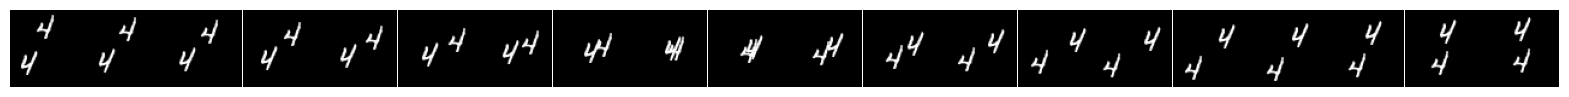

In [13]:
plot_model_result(x, 'AE_gt', 20, n = 1)

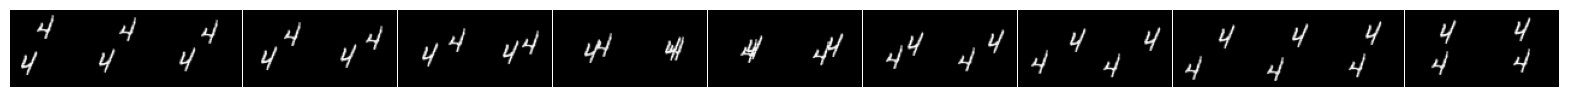

In [14]:
plot_model_result(pred, 'AE_rec', 20, n = 1)